# Exploratory Data Analysis

Our task is to develop a system that provides accurate medical information that successfully answers the question given by the user. Provided to us is a dataset of questions and answers. We may use this dataset to understand the kind of data our model is expected to work with, as well as the desired level of performance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dset_path = "../data/intern_screening_dataset.csv"
original_qa_df = pd.read_csv(dset_path)

qa_df = original_qa_df.copy()

qa_df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."


In [2]:
qa_df.describe()

,question,answer
count,16406,16401
unique,14981,15811
top,What causes Causes of Diabetes ?,This condition is inherited in an autosomal re...
freq,20,348


The dataset consists of 16406 entries of questions and answers related to medical information. 

## Data Integrity
From the table above, we can already identify some questions of interest to investigate about the data:
- Why is there a discrepancy in the number of questions and answers?
- Why are there several non-unique entries in both questions and answers?


Given that the dataset is composed of strings of variable length, and that as such it is hard to fully inspect the data using pandas' methods, let's define a helper function that standardizes printing for us

In [3]:
def pretty_print_row(row):
    print("============================")
    print("Q:", row['question'])
    print("A:", row['answer'])

### Q: Why is there a discrepacy in the number of questions and answers?

There appear to be 5 less questions than answers. This probably means that our data contains some NaNs. Let's verify

In [4]:
qa_df.isna().sum()

question    0
answer      5
dtype: int64

There are 5 questions that have been left unanswered, which amounts to .03% of the data. Let's see which ones are they

In [5]:
unanswered_df = qa_df[qa_df.isna().any(axis=1)]
for _, row in unanswered_df.iterrows():
    pretty_print_row(row)

Q: What is (are) HELLP syndrome ?
A: nan
Q: What is (are) X-linked lymphoproliferative syndrome ?
A: nan
Q: What is (are) Familial HDL deficiency ?
A: nan
Q: What is (are) Emery-Dreifuss muscular dystrophy, X-linked ?
A: nan
Q: What is (are) Emery-Dreifuss muscular dystrophy, dominant type ?
A: nan


Given that these questions have no answer, our best option is to remove them from our dataset. However, as a safety measure, we would like to see if the topics in these questions are covered in the rest of our dataset

In [6]:
# Since this is only 5 questions, we can just check directly for relevant information. 
# If we had more questions to investigate, we would have to find a way to streamline this
topics_of_interest = ["HELLP syndrome", "X-linked lymphoproliferative syndrome", "Familial HDL deficiency", "Emery-Dreifuss muscular dystrophy"]

for topic in topics_of_interest:
    print(f"\n\nQuestions related to {topic}:")
    topic_questions = qa_df[qa_df['question'].str.contains(topic, case=False)]
    num_questions = len(topic_questions)
    print(f"Number of related questions: {num_questions}")



Questions related to HELLP syndrome:
Number of related questions: 3


Questions related to X-linked lymphoproliferative syndrome:
Number of related questions: 4


Questions related to Familial HDL deficiency:
Number of related questions: 7


Questions related to Emery-Dreifuss muscular dystrophy:
Number of related questions: 8


The unanswered questions appear to be covered by a few other questions in the data, so we can assume that the topics are covered and therefore safe to remove

In [7]:
qa_df = qa_df.dropna()

### Q: Why are there several non-unique entries in both questions and answers?
Duplicate entries can be an issue with our dataset, regardless of how it will be used. Duplicate entries will bias the machine learning process, by either acting as a weighting factor in the training process, or by being overrepresented in the evaluation scores. Answering this question will also cover some additional questions:

- Is there an intersection between duplicate questions and answers?

Additionally, looking at the description of the data, the number of duplicate questions is larger than the number of duplicate answers, so even if assuming that all duplicate answers match with a duplicate question, there would be questions that are repeated but contain different answers

- Are duplicate questions with unique answers an issue?

### Q: Is there an intersection between duplicate questions and answers?
To answer this, we can get the duplicate rows and count how many there are. This would give us an idea of the size of the intersection

In [8]:
duplicates_df = qa_df[qa_df['answer'].duplicated(keep=False) & qa_df['question'].duplicated(keep=False)]
duplicates_df = duplicates_df.sort_values(by=['question', 'answer'])
print(f"Number of duplicate questions: {len(duplicates_df)}")

for _, row in duplicates_df.iloc[:6].iterrows():
    pretty_print_row(row)

Number of duplicate questions: 122
Q: How to diagnose Glomerular Diseases ?
A: Patients with glomerular disease have significant amounts of protein in the urine, which may be referred to as "nephrotic range" if levels are very high. Red blood cells in the urine are a frequent finding as well, particularly in some forms of glomerular disease. Urinalysis provides information about kidney damage by indicating levels of protein and red blood cells in the urine. Blood tests measure the levels of waste products such as creatinine and urea nitrogen to determine whether the filtering capacity of the kidneys is impaired. If these lab tests indicate kidney damage, the doctor may recommend ultrasound or an x ray to see whether the shape or size of the kidneys is abnormal. These tests are called renal imaging. But since glomerular disease causes problems at the cellular level, the doctor will probably also recommend a kidney biopsya procedure in which a needle is used to extract small pieces of ti

Out of all the duplicate questions and answers, only 122 are row-level duplicates. These entries are the simplest to handle, which can be done by removing exact duplicates. Before doing so, let's inspect how duplicate questions behave

In [9]:
q_duplicates_df = qa_df[(qa_df['question'].duplicated(keep=False)) & (~qa_df['answer'].duplicated(keep=False))]
q_duplicates_df = q_duplicates_df.sort_values(by=['question', 'answer'])
print(f"Number of duplicate questions: {len(q_duplicates_df)}")

for _, row in q_duplicates_df.iloc[:6].iterrows():
    pretty_print_row(row)

Number of duplicate questions: 2192
Q: How to diagnose Adrenal Insufficiency and Addison's Disease ?
A: After Addisons disease is diagnosed, health care providers may use the following tests to look at the adrenal glands, find out whether the disease is related to TB, or identify antibodies associated with autoimmune Addisons disease.
                
- Ultrasound of the abdomen. Ultrasound uses a device, called a transducer, that bounces safe, painless sound waves off organs to create an image of their structure. A specially trained technician performs the procedure in a health care providers office, an outpatient center, or a hospital, and a radiologista doctor who specializes in medical imaginginterprets the images; a patient does not need anesthesia. The images can show abnormalities in the adrenal glands, such as enlargement or small size, nodules, or signs of calcium deposits, which may indicate bleeding.   - Tuberculin skin test. A tuberculin skin test measures how a patients im

There appear to be a few questions that have different answers. Wether or not this is an issue is debatable, but most often than not it could be considered bad practice. As stated before, duplicate entries will be more representative of the final score, which can bias the analysis towards those questions. If a question has multiple, high quality responses, that are relevant to the question and demonstrate varied ways to answer correctly, it could be an useful way to have more robust evaluations.

That being said, a quick inspection of the data demonstrates that some of the duplicate questions contain non-relevant answers. For example: `How to diagnose Alzheimer's disease ?` has two different answers, out of which only one seems to discuss actual methods to diagnose the disease. Assuming lack of expertise from the data scientist, **this should prompt an investigation of the quality of the data from experts in the field**. To avoid possible issues that can arise from this discrepancy, **the duplicate questions will also be removed**.

Lastly, let's investigate the duplicate answers

In [10]:
a_duplicates_df = qa_df[(~qa_df['question'].duplicated(keep=False)) & (qa_df['answer'].duplicated(keep=False))]
a_duplicates_df = a_duplicates_df.sort_values(by=['answer', 'question'])
print(f"Number of duplicate questions: {len(a_duplicates_df)}")

for _, row in a_duplicates_df.iloc[:12].iterrows():
    pretty_print_row(row)

Number of duplicate questions: 552
Q: What is (are) Achondrogenesis ?
A: Achondrogenesis is a group of severe disorders that are present from birth and affect the development of cartilage and bone. Infants with achondrogenesis usually have a small body, short arms and legs, and other skeletal abnormalities that cause life-threatening complications.  There are at least three forms of achondrogenesis, type 1A, type 1B and type 2, which are distinguished by signs and symptoms, pattern of inheritance, and the results of imaging studies such as x-rays (radiology), tissue analysis (histology), and genetic testing.  Type 1A and 1B achondrogenesis are both inherited in an autosomal recessive pattern.  Type 1B may be caused by mutations in the SLC26A2 gene.  Type 2 achondrogenesis is inherited in an autosomal dominant pattern and is caused by new (de novo) mutations in the COL2A1 gene.
Q: What is (are) Achondrogenesis type 1A ?
A: Achondrogenesis is a group of severe disorders that are present 

Duplicate answers to different questions, even if similar, should prompt a re-evaluation of the specificity of the answers. This sets seems to comprise exact answers to more specific questions about some medical topics. For example, exact same responses are given to questions that go deeper into the different types of syndromes of diseases. This might indicate that these entries do not represent helpful answers to the given questions. Still, eliminating all of the answers given above could be wasteful, as they most probably convey information relevant to the questions, even if not specific enough. While in a real life setting it would be best to raise this issue to the stakeholders to ensure it is handled appropiately, for this scenario these duplicate answers will also be removed.

In [11]:
qa_df = qa_df.drop_duplicates(subset=['question'])
qa_df = qa_df.drop_duplicates(subset=['answer'])
print(qa_df.describe())

print("Percentage of retained data:", len(qa_df) / len(original_qa_df))

                        question  \
count                      14460   
unique                     14460   
top     What is (are) Glaucoma ?   
freq                           1   

                                                   answer  
count                                               14460  
unique                                              14460  
top     Glaucoma is a group of diseases that can damag...  
freq                                                    1  
Percentage of retained data: 0.8813848591978545


After cleaning up the data, we retained ~88% of the original dataset. While the amount of dropped rows is significant, the amount of retained entries should still be enough to allow for experimentation and/or evaluation. As discussed before, in a real world scenario some alternative measures can be taken for retaining more entries, by validating the quality of the data on offending entries with some experts on the field

## Text-related statistics
After having validated the integrity of the data, it might be worth to investigate the contents. Some relevant questions to investigate are:
- How does the length of the questions and answers behave?
- What are relevant representative words?

### Q: How does the length of the questions and answers behave?
This can give us an idea of the context size that the model should have to be able to provide the expected detail for most if not all responses

In [12]:
q_len = qa_df.apply(lambda x: len(x['question']), axis=1)
a_len = qa_df.apply(lambda x: len(x['answer']), axis=1)

print("Question Length Statistics:")
print(q_len.describe())
print()
print("Answer Length Statistics:")
print(a_len.describe())

Question Length Statistics:
count    14460.000000
mean        51.771024
std         16.790032
min         16.000000
25%         40.000000
50%         50.000000
75%         62.000000
max        191.000000
dtype: float64

Answer Length Statistics:
count    14460.000000
mean      1317.253873
std       1649.873110
min          6.000000
25%        512.000000
50%        904.000000
75%       1605.250000
max      27910.000000
dtype: float64


The variability of the questions is relatively small, averaging at ~52 characters with a standard deviation of ~17. On the other hand, responses have a wide range of lengths, with a standard deviation of ~1650 and a mean of ~1317. Let's inspect the extremes of both columns

In [13]:
qa_df.sort_values(by="question", key=lambda x: x.str.len()).head()

,question,answer
7881,What is (are) ?,On this Page General Information What is vanco...
8060,what is botulism?,Botulism is a rare but serious paralytic illne...
8079,How to prevent ?,Vaccines and Preventable Diseases On this Page...
689,What causes Gout ?,A Buildup of Uric Acid Most people with gout h...
8269,What causes ARDS ?,Many conditions or factors can directly or ind...


In [14]:
large_q = qa_df.sort_values(by="question", key=lambda x: x.str.len(), ascending=False).head()

for _, row in large_q.iterrows():
    pretty_print_row(row)

Q: what research (or clinical trials) is being done for National Hormone and Pituitary Program (NHPP): Information for People Treated with Pituitary Human Growth Hormone (Comprehensive Report) ?
A: Although CJD is a rare disorder, some of the world's leading researchers are working hard to learn more about this disease.
                
About 10 percent of the people who get CJD have the inherited type. Some people have gotten CJD from medical procedures such as pituitary hGH injections, tissue grafts, or corneal transplants. Scientists don't fully understand what causes CJD. Evidence suggests that a unique infectious agent called a prion [PREE-on] may be the cause. A prion is an unusual infectious agent because it contains no genetic material. It is a protein that takes on different forms. In its normal, harmless form, the protein is curled into a spiral. In its infectious form, the protein folds into an abnormal shape. Somehow, these abnormal proteins change the shape of normal prote

Based on the extreme ends of the question length spectrum, we can identify a few extra issues with the data. Some questions are malformed or incomplete, which means that they should not be included in the dataset. Identifying such questions should be something that is either done, or monitored by an expert in the field. For the purpose of this project, these questions will be left in the data, as identifying troublesome content is out of the scope.

On the other end of the spectrum, we can see that some questions are highly specific, possibly referencing specific studies. This may imply that the application will be used for similar queries of other studies. Depending on accessibility, this may guide our architecture towards either implementing and sustaining a RAG system that is constantly being updated with recent studies, or using external services like Tavily for allowing web search access. For now, these will be considered as possible avenues for improvements

In [15]:
short_a = qa_df.sort_values(by="answer", key=lambda x: x.str.len()).head(10)

for _, row in short_a.iterrows():
    pretty_print_row(row)

Q: How to prevent Acanthamoeba - Granulomatous Amebic Encephalitis (GAE); Keratitis ?
A: Topics
Q: What causes Bell's palsy ?
A: What causes Bell's palsy?
Q: Is Williams syndrome inherited ?
A: Is Williams syndrome inherited?
Q: How many people are affected by blepharophimosis, ptosis, and epicanthus inversus syndrome ?
A: The prevalence of BPES is unknown.
Q: What is (are) Parasites - African Trypanosomiasis (also known as Sleeping Sickness) ?
A: Frequently Asked Queestions (FAQs)
Q: What are the treatments for Bell's palsy ?
A: How might Bell's palsy be treated?
Q: Is 48,XXYY syndrome inherited ?
A: Can 48,XXYY syndrome be inherited?
Q: Is Septo-optic dysplasia inherited ?
A: Is septo-optic dysplasia inherited?
Q: What are the symptoms of Bell's palsy ?
A: What are the symptoms of Bell's palsy?
Q: What is the outlook for Agnosia ?
A: Agnosia can compromise quality of life.


In [16]:
large_a = qa_df.sort_values(by="answer", key=lambda x: x.str.len(), ascending=False).head()

for _, row in large_a.iterrows():
    pretty_print_row(row)

Q: What is (are) Childhood Vascular Tumors ?
A: Key Points
                    - Childhood vascular tumors form from cells that make blood vessels or lymph vessels.    - Tests are used to detect (find) and diagnose childhood vascular tumors.    - Childhood vascular tumors may be classified into four groups.         - Benign tumors     - Intermediate (locally aggressive) tumors     - Intermediate (rarely metastasizing) tumors     - Malignant tumors
                
                
                    Childhood vascular tumors form from cells that make blood vessels or lymph vessels.
                    Vascular tumors can form from abnormal blood vessel or lymph vessel cells anywhere in the body. They may be benign (not cancer) or malignant (cancer). There are many types of vascular tumors. The most common type of childhood vascular tumor is hemangioma, which is a benign tumor that usually goes away on its own.   Because malignant vascular tumors are rare in children, there is not a lo

When it comes to answers, the extremes appear to demonstrate non-helpful responses to the given queries. Short answers are usually follow-up questions, or don't provide the expected level of detail. For longer responses, the answers appear to repeat content, as well as go beyond the specific question, complementing with additional questions. It might be safe to assume that the extremes for questions are not useful for our task. Let's visualize the response length distribution

<Axes: >

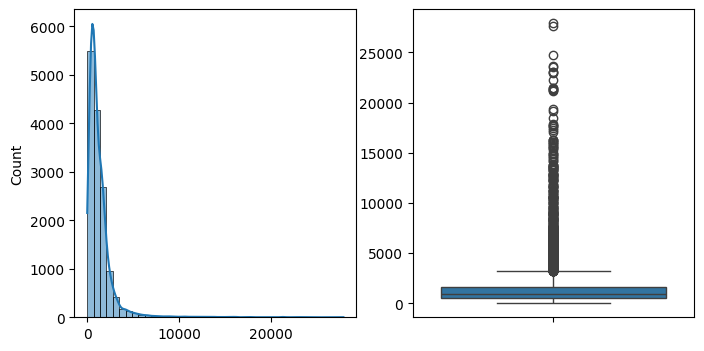

In [20]:

a_len_df = qa_df.apply(lambda x: len(x['answer']), axis=1)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(a_len_df, bins=40, kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(a_len_df)

We can observe an extreme right-skewed distribution. A simple method to handle outliers due to response length is by imposing a limit based on quantiles. Given the skewness, we will use a more conservative value for our lower limit of 1% of the data, while for the upper limit we will use the standard 95%.

In [30]:
upper_limit = qa_df['answer'].apply(lambda x: len(x)).quantile(0.95)
print("Upper limit for answer length:", upper_limit)

lower_limit = qa_df['answer'].apply(lambda x: len(x)).quantile(0.01)
print("Lower limit for answer length:", lower_limit)

len_outliers = qa_df[(qa_df['answer'].apply(lambda x: len(x)) > upper_limit) | (qa_df['answer'].apply(lambda x: len(x)) < lower_limit)]

for _, row in len_outliers.sample(5).iterrows():
    pretty_print_row(row)

Upper limit for answer length: 3356.199999999997
Lower limit for answer length: 73.0
Q: How to diagnose Diabetic Heart Disease ?
A: Your doctor will diagnose diabetic heart disease (DHD) based on your signs and symptoms, medical and family histories, a physical exam, and the results from tests and procedures.
                
Doctors and researchers are still trying to find out whether routine testing for DHD will benefit people who have diabetes but no heart disease symptoms.
                
Initial Tests
                
No single test can diagnose DHD, which may involve coronary heart disease (CHD), heart failure, and/or diabetic cardiomyopathy. Initially, your doctor may recommend one or more of the following tests.
                
Blood Pressure Measurement
                
To measure your blood pressure, your doctor or nurse will use some type of a gauge, a stethoscope (or electronic sensor), and a blood pressure cuff.
                
Most often, you'll sit or lie down with th

In [32]:
qa_df = qa_df[(qa_df['answer'].apply(lambda x: len(x)) <= upper_limit) & (qa_df['answer'].apply(lambda x: len(x)) >= lower_limit)]
qa_df.describe()

,question,answer
count,13593,13593
unique,13593,13593
top,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
freq,1,1


After outlier handling, our dataset is now comprised of 13593 cases. This is still a relatively large dataset, and we have now taken some measurements to identify and handle issues.

### Q. What are relevant representative words?

Understanding which words are representative on the dataset can help us identify possible external datasets that are related and can therefore add value to the task. For this, we can use NLTK to remove stop words and lemmatize the text. By standardizing and removing noise, we should be able to detect relevant words in the data

In [46]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords(text: str) -> str:
    # nltk doesn't remove punctuation, so let's do that with regex
    text = re.sub(r'[^\w]', ' ', text)
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if w.lower() not in stop_words]
    return ' '.join(filtered_sentence)

def lemmatize(text: str) -> str:
    word_tokens = word_tokenize(text)
    lemmatized_sentence = [lemmatizer.lemmatize(w) for w in word_tokens]
    return ' '.join(lemmatized_sentence)

answer_words_df = qa_df['answer'].apply(remove_stopwords).apply(lemmatize).str.split()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alejandroaristizabal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [48]:
answer_word_count = answer_words_df.explode().value_counts()
answer_word_count.head(20)

answer
symptom        24124
may            18166
people         14629
sign           14369
condition      13658
frequency      10703
gene           10596
information    10351
patient         9712
syndrome        9299
number          9296
disease         9146
cell            8869
cause           8297
also            7651
90              7170
available       7010
study           6987
5               6847
often           6825
Name: count, dtype: int64

In [49]:
answer_word_count.tail(20)

answer
polariscopic             1
intensely                1
osteoma                  1
Fundic                   1
Fibroadenoma             1
Odontogenic              1
Osteoma                  1
Sulindac                 1
striped                  1
delirious                1
ectropium                1
penetrate                1
Classically              1
appreciated              1
disputed                 1
acetylglucosaminidase    1
Mitten                   1
Phimosis                 1
alkalization             1
fork                     1
Name: count, dtype: int64

## Exploring other datasets
The dataset provided for the task demonstrates the desired behavior of our machine learning pipeline. Because of this, it might be useful to consider it for evaluation purposes, while using other sources to complement our pipeline. Because of this, we want to explore what other relevant sources are there and how they can be used. Huggingface provides a huge repository of data for different topics, needs and use-cases. From a quick investigation of their repositories, the following dataset comes to mind:

- `gamino/wiki_medical_terms`: This dataset contains ~6.86k rows of medical terms, accompanied of detailed description of each term, including signs, symptoms, causes, etc of conditions.

We've also identified `keivalya/MedQuad-MedicalQnADataset` as the source of the originally provided datset.

In [62]:
from datasets import load_dataset

wiki_medical = load_dataset("gamino/wiki_medical_terms")
for i in range(5):
    print("Page Title:", wiki_medical['train']['page_title'][i])
    print("Page Text:", wiki_medical['train']['page_text'][i][:500])
    print("\n")

Page Title: Paracetamol poisoning
Page Text: Paracetamol poisoning, also known as acetaminophen poisoning, is caused by excessive use of the medication paracetamol (acetaminophen). Most people have few or non-specific symptoms in the first 24 hours following overdose. These include feeling tired, abdominal pain, or nausea. This is typically followed by a couple of days without any symptoms, after which yellowish skin, blood clotting problems, and confusion occurs as a result of liver failure. Additional complications may include kidney fai


Page Title: Acromegaly
Page Text: Acromegaly is a disorder that results from excess growth hormone (GH) after the growth plates have closed. The initial symptom is typically enlargement of the hands and feet. There may also be an enlargement of the forehead, jaw, and nose. Other symptoms may include joint pain, thicker skin, deepening of the voice, headaches, and problems with vision. Complications of the disease may include type 2 diabetes, sleep 

This dataset has the potential of being a source of truth for unseen queries, which points towards implementing a RAG system as a plausible solution to our problem. A great advantage of a RAG system is that it doesn't require model fine-tuning, since it instead uses a vector database to retrieve relevant information and enrich the prompt context. This makes it a low-cost first step solution, that can usually be sufficient for the needs of the stakeholders.

## Conclusion
After analyzing the original dataset, we were able to identify and resolve several issues with the data. We ended up with approximately 13600 examples of medical-related questions and their accompanying answers. We also provided some next steps that could be taken to improve the quality and quantity of the data.

We determined that a RAG system would be a suitable solution, and established that the original data could be used for evaluating the performance of such system. Since RAGs don't require model training or fine-tuning, the data will not be used for that purpose.

Finally, we identified a potential data source to complement our task, which seems to be a suitable source-of-truth to construct our RAG system. 